NOTEBOOK DESCRIPTION
This script focuses on building and evaluating machine learning classifiers to predict the career longevity of NBA rookies, specifically whether a player will last five or more years in the league. 

The script follows a systematic approach: loading and preprocessing a dataset of player statistics, applying feature scaling and handling class imbalance with SMOTE, and evaluating various classifiers such as Support Vector Machines (SVC), Random Forests, Logistic Regression, and others. 

The performance of each model is assessed using metrics such as recall and AUC-ROC. 

The best-performing model is then tuned via hyperparameter optimization. 

The final model is evaluated on a test set, and its feature importance (for tree-based models) and ROC curve are plotted to provide insights into the model’s predictions.

In [1]:
# ==================================================================
# IMPORT LIBRARIES
# ==================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import (confusion_matrix, recall_score, classification_report,
                             roc_auc_score, roc_curve, auc)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from IPython.display import display

# Configuration
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

In [2]:
# ==================================================================
# FONCTIONS
# ==================================================================
def set_plot_style():
    """
    Set the style for matplotlib plots.
    This function customizes the appearance of matplotlib plots by adjusting
    parameters such as font size, axis title size, line width, and marker size. 
    It ensures a consistent visual style for all plots.
    
    Parameters:
        None

    Returns:
        None
    """
    
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold',
        'lines.linewidth': 3,
        'lines.markersize': 10,
        'axes.titlepad': 20
    })

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the data.
    This function reads a CSV file, processes the data, and prepares it for model training.
    It extracts player names, target labels (TARGET_5Yrs), and features. It also handles
    missing values by replacing NaNs with 0 and normalizes the features using MinMaxScaler.

    Parameters:
        file_path (str): The path to the CSV file containing the data.

    Returns:
        X (numpy.ndarray): Preprocessed feature matrix.
        labels (numpy.ndarray): Target labels (1 for >= 5 years, 0 for < 5 years).
        features.columns (Index): Names of the features used for training.
        names (list): List of player names corresponding to the samples.
    """
    
    df = pd.read_csv(file_path)
    display(df.head())
    
    names = df['Name'].values.tolist()
    labels = df['TARGET_5Yrs'].values
    features = df.drop(['TARGET_5Yrs', 'Name'], axis=1)
    
    # Replace NaN values and normalize
    scaler = MinMaxScaler()
    X = scaler.fit_transform(np.nan_to_num(features.values, nan=0.0))
    
    return X, labels, features.columns, names, scaler

def score_classifier(X, y, classifier):
    """
    Perform cross-validation and return performance metrics.
    This function trains and evaluates a given classifier using k-fold cross-validation.
    It computes the confusion matrix, recall scores, and AUC-ROC scores for each fold.
    The function returns the average recall and AUC-ROC across the folds.

    Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Target labels.
        classifier (sklearn classifier): A classifier to be evaluated.

    Returns:
        avg_recall (float): Average recall score across all folds.
        avg_auc_roc (float): Average AUC-ROC score across all folds.
    """
    
    kf = KFold(n_splits=3, random_state=50, shuffle=True)
    confusion_mat = np.zeros((2, 2))
    recall_scores = []
    auc_roc_scores = []
    optimal_thresholds = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        classifier.fit(X_train, y_train)
        
        y_prob = classifier.predict_proba(X_test)[:, 1] if hasattr(classifier, "predict_proba") else classifier.predict(X_test)
        
        # Find optimal threshold
        optimal_threshold = find_optimal_threshold(y_test, y_prob)
        optimal_thresholds.append(optimal_threshold)
        
        # Use optimal threshold for predictions
        y_pred = (y_prob >= optimal_threshold).astype(int)
        
        confusion_mat += confusion_matrix(y_test, y_pred)
        recall_scores.append(recall_score(y_test, y_pred))
        auc_roc_scores.append(roc_auc_score(y_test, y_prob))
    
    avg_recall = np.mean(recall_scores)
    avg_auc_roc = np.mean(auc_roc_scores)
    avg_threshold = np.mean(optimal_thresholds)
    
    print(f"Confusion Matrix:\n{confusion_mat}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average AUC ROC: {avg_auc_roc:.4f}")
    print(f"Average Optimal Threshold: {avg_threshold:.4f}")
    
    return avg_recall, avg_auc_roc, avg_threshold

def evaluate_classifiers(X, y):
    """
    Evaluate multiple classifiers and return results.
    This function tests multiple classifiers on the given dataset and computes performance
    metrics such as recall and AUC-ROC for each one. The classifiers tested include SVC,
    RandomForest, LogisticRegression, MLPClassifier, GradientBoosting, XGBoost, AdaBoost, and
    KNeighbors. The function returns a DataFrame with sorted results based on average recall
    and AUC-ROC.

    Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Target labels.

    Returns:
        pandas.DataFrame: A sorted DataFrame containing the classifiers and their average performance.
    """
    classifiers = {
        'SVC': SVC(class_weight='balanced', probability=True),
        'RandomForest': RandomForestClassifier(class_weight='balanced'),
        'LogisticRegression': LogisticRegression(class_weight='balanced'),
        'MLPClassifier': MLPClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'AdaBoost': AdaBoostClassifier(),
        'KNeighbors': KNeighborsClassifier()
    }
    
    results = []
    for name, clf in classifiers.items():
        print(f"\nEvaluating {name}:")
        recall, auc_roc, optimal_threshold = score_classifier(X, y, clf)
        results.append({
            'Classifier': name,
            'Recall': recall,
            'AUC_ROC': auc_roc,
            'Average': (recall + auc_roc) / 2,
            'Optimal_Threshold': optimal_threshold
        })
    
    return pd.DataFrame(results).sort_values(by='Average', ascending=False)

def get_param_grid(classifier_name):
    """
    Return the parameter grid for a given classifier.
    This function provides predefined hyperparameter grids for different classifiers.
    It helps in hyperparameter tuning by returning the corresponding grid for the requested
    classifier.

    Parameters:
        classifier_name (str): Name of the classifier for which the parameter grid is requested.

    Returns:
        dict: Hyperparameter grid for the requested classifier.
    """
    param_grids = {
        'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto']},
        'RandomForest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]},
        'LogisticRegression': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
        'GradientBoosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
        'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
        'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
        'KNeighbors': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
        'MLPClassifier': {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 'alpha': [0.0001, 0.001, 0.01]}
    }
    return param_grids.get(classifier_name, {})



def tune_hyperparameters(X, y, best_classifier):
    """
    Perform hyperparameter tuning for the best classifier.
    This function tunes the hyperparameters of a given classifier using GridSearchCV.
    It finds the optimal hyperparameters for maximizing recall score.

    Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Target labels.
        best_classifier (str): Name of the classifier to be tuned.

    Returns:
        sklearn classifier: Best estimator with tuned hyperparameters.
    """
    if best_classifier not in CLASSIFIERS:
        raise ValueError(f"Classifier '{best_classifier}' not recognized")
    
    clf = CLASSIFIERS[best_classifier]()
    param_grid = get_param_grid(best_classifier)
    
    grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='recall', refit='roc_auc', n_jobs=-1)
    grid_search.fit(X, y)
    
    print("\nBest parameters:", grid_search.best_params_)
    print("Best recall score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

def plot_feature_importance(model, feature_names):
    """
    Plot feature importance for tree-based models.
    This function visualizes the top 10 most important features of a model that supports
    feature importances (e.g., tree-based models such as RandomForest). It creates a barplot
    to display the importance of the features.

    Parameters:
        model (sklearn classifier): A trained tree-based model.
        feature_names (list): List of feature names corresponding to the model's input features.

    Returns:
        None
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_imp = pd.DataFrame(sorted(zip(importances, feature_names)), columns=['Value', 'Feature'])
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
        plt.title('Top 10 Most Important Features')
        plt.tight_layout()
        plt.show()

def plot_roc_curve(y_true, y_prob):
    """
    Plot the ROC curve.
    This function generates a Receiver Operating Characteristic (ROC) curve based on the 
    true labels and predicted probabilities. It calculates the Area Under the Curve (AUC) 
    and visualizes the ROC curve.

    Parameters:
        y_true (numpy.ndarray): True binary labels.
        y_prob (numpy.ndarray): Predicted probabilities for the positive class.

    Returns:
        None
    """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def find_optimal_threshold(y_true, y_prob):
    """
    Find the optimal threshold for classification using Youden's J statistic.
    
    Parameters:
        y_true (numpy.ndarray): True binary labels.
        y_prob (numpy.ndarray): Predicted probabilities for the positive class.
    
    Returns:
        float: Optimal threshold for classification.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def plot_precision_recall_curve(y_true, y_prob, threshold):
    """
    Plot the Precision-Recall curve and mark the point for the chosen threshold.
    
    Parameters:
        y_true (numpy.ndarray): True binary labels.
        y_prob (numpy.ndarray): Predicted probabilities for the positive class.
        threshold (float): Chosen classification threshold.
    
    Returns:
        None
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    average_precision = average_precision_score(y_true, y_prob)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.axhline(y=0.5, color='red', linestyle='--', label='No Skill')
    
    # Mark the point for the chosen threshold
    idx = np.argmin(np.abs(thresholds - threshold))
    plt.plot(recall[idx], precision[idx], 'ro', markersize=10, label=f'Chosen threshold ({threshold:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

1. LOAD and PREPROCESS DATA


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,PER,PPM,Usage_Rate,True_Shooting_Percentage,Effective_FG_Percentage,Points_Per_Shot,Total_Rebound_Percentage,Offensive_Rebound_Percentage,Defensive_Rebound_Percentage,Assist_Percentage,AST_Ratio,Steal_Percentage,Block_Percentage,Stocks,Versatility_Index,Offensive_Versatility,Defensive_Versatility,Three_Point_Rate,Free_Throw_Rate,PTS_Per_Game,PTS_Per_36,REB_Per_Game,REB_Per_36,AST_Per_Game,AST_Per_36,STL_Per_Game,STL_Per_36,BLK_Per_Game,BLK_Per_36,TOV_Per_Game,TOV_Per_36,Box_Plus_Minus,Scoring_Consistency,Usage_Consistency,Offensive_Impact,Defensive_Impact,Overall_Impact,Points_Per_Touch,Production_Per_Possession,PTS_to_Usage_Ratio,AST_to_Usage_Ratio,2P%,Points_Per_Shot_Attempt,Physical_Impact
0,Greg Anderson,82,24.2,11.7,4.6,9.2,50.00,0.0,0.1,0.00,2.4,4.0,60.00,2.0,4.3,6.3,1.0,0.7,1.5,1.7,1.0,0.24,0.48,0.52,0.53,0.50,1.07,0.15,4.84e-02,0.10,4.84e-03,10.87,0.02,3.63e-02,2.2,21.2,14.7,6.5,0.01,0.43,0.14,17.40,0.08,9.37,0.01,1.49,8.54e-03,1.04,1.83e-02,2.23,0.02,2.53,0.13,0.89,6.38e-03,0.52,0.27,0.79,0.74,1.38,22.36,1.91,0.51,1.27,0.35
1,Bimbo Coles,82,16.5,4.9,2.0,4.8,41.67,0.1,0.4,25.00,0.9,1.2,75.00,0.7,1.2,1.9,2.8,0.8,0.1,1.2,1.0,0.11,0.30,0.40,0.46,0.43,0.92,0.07,2.48e-02,0.04,1.99e-02,58.33,0.03,3.55e-03,0.9,10.5,8.4,2.1,0.08,0.25,0.06,10.69,0.02,4.15,0.03,6.11,9.76e-03,1.75,1.22e-03,0.22,0.01,2.62,0.12,0.82,4.82e-03,0.47,0.13,0.59,0.49,1.44,12.39,7.08,0.43,1.02,0.17
2,Paul Thompson,82,21.1,9.0,3.8,8.1,46.91,0.1,0.5,20.00,1.4,1.8,77.78,1.5,2.3,3.8,1.5,0.8,0.5,0.9,0.0,0.18,0.43,0.46,0.51,0.48,1.01,0.11,4.16e-02,0.06,8.32e-03,18.52,0.02,1.39e-02,1.3,15.6,12.0,3.6,0.06,0.22,0.11,15.36,0.05,6.48,0.02,2.56,9.76e-03,1.36,6.10e-03,0.85,0.01,1.54,0.12,0.91,5.66e-03,0.50,0.17,0.67,0.73,1.45,19.39,3.23,0.49,1.11,0.24
3,Chris Duhon,82,26.5,5.9,2.1,6.0,35.00,1.1,3.2,34.38,0.6,0.8,75.00,0.3,2.3,2.6,4.9,1.0,0.0,1.4,1.0,0.16,0.22,0.29,0.46,0.44,0.93,0.06,6.63e-03,0.05,2.16e-02,81.67,0.02,0.00e+00,1.0,14.4,11.1,3.3,0.53,0.13,0.07,8.02,0.03,3.53,0.06,6.66,1.22e-02,1.36,0.00e+00,0.00,0.02,1.90,0.20,0.87,3.57e-03,0.41,0.12,0.53,0.45,1.49,20.17,16.75,0.36,0.98,0.14
4,Joe Dumars*,82,23.9,9.4,3.5,7.3,47.95,0.1,0.2,50.00,2.3,2.9,79.31,0.7,0.7,1.5,4.8,0.8,0.1,1.9,1.0,0.18,0.39,0.44,0.55,0.49,1.10,0.04,1.71e-02,0.02,2.35e-02,65.75,0.02,2.45e-03,0.9,16.6,14.9,1.6,0.03,0.40,0.11,14.16,0.02,2.26,0.06,7.23,9.76e-03,1.21,1.22e-03,0.15,0.02,2.86,0.20,0.92,5.35e-03,0.59,0.07,0.66,0.56,1.52,21.45,10.95,0.48,1.29,0.10


2. SPLIT DATA
3. APPLY SMOTE
4. EVALUATE CLASSIFIERS

Evaluating SVC:
Confusion Matrix:
[[448. 193.]
 [167. 474.]]
Average Recall: 0.7378
Average AUC ROC: 0.7702
Average Optimal Threshold: 0.4849

Evaluating RandomForest:
Confusion Matrix:
[[467. 174.]
 [120. 521.]]
Average Recall: 0.8127
Average AUC ROC: 0.8281
Average Optimal Threshold: 0.4567

Evaluating LogisticRegression:
Confusion Matrix:
[[431. 210.]
 [146. 495.]]
Average Recall: 0.7708
Average AUC ROC: 0.7730
Average Optimal Threshold: 0.4581

Evaluating MLPClassifier:


D:\ANACONDA\envs\OC_PROJECT6_WITH_TENSORFLOW\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\ANACONDA\envs\OC_PROJECT6_WITH_TENSORFLOW\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\ANACONDA\envs\OC_PROJECT6_WITH_TENSORFLOW\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[474. 167.]
 [199. 442.]]
Average Recall: 0.6865
Average AUC ROC: 0.7665
Average Optimal Threshold: 0.4777

Evaluating GradientBoosting:
Confusion Matrix:
[[444. 197.]
 [132. 509.]]
Average Recall: 0.7941
Average AUC ROC: 0.8003
Average Optimal Threshold: 0.4244

Evaluating XGBoost:
Confusion Matrix:
[[505. 136.]
 [169. 472.]]
Average Recall: 0.7348
Average AUC ROC: 0.8170
Average Optimal Threshold: 0.4798

Evaluating AdaBoost:


D:\ANACONDA\envs\OC_PROJECT6_WITH_TENSORFLOW\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
D:\ANACONDA\envs\OC_PROJECT6_WITH_TENSORFLOW\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
D:\ANACONDA\envs\OC_PROJECT6_WITH_TENSORFLOW\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix:
[[494. 147.]
 [233. 408.]]
Average Recall: 0.6350
Average AUC ROC: 0.7409
Average Optimal Threshold: 0.5011

Evaluating KNeighbors:
Confusion Matrix:
[[506. 135.]
 [236. 405.]]
Average Recall: 0.6304
Average AUC ROC: 0.7615
Average Optimal Threshold: 0.6000


,Classifier,Recall,AUC_ROC,Average,Optimal_Threshold
1,RandomForest,0.81,0.83,0.82,0.46
4,GradientBoosting,0.79,0.80,0.80,0.42
5,XGBoost,0.73,0.82,0.78,0.48
2,LogisticRegression,0.77,0.77,0.77,0.46
0,SVC,0.74,0.77,0.75,0.48
3,MLPClassifier,0.69,0.77,0.73,0.48
7,KNeighbors,0.63,0.76,0.70,0.60
6,AdaBoost,0.63,0.74,0.69,0.50



Best performing classifier: RandomForest
Optimal threshold for best classifier: 0.4567
5. HYPERPARAMETER TUNING

Best parameters: {'max_depth': None, 'n_estimators': 100}
Best recall score: 0.7331110233571732
6. FINAL EVALUATION ON TEST DATASET
Final model performance on test set:
              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62        94
         1.0       0.78      0.79      0.79       165

    accuracy                           0.73       259
   macro avg       0.70      0.70      0.70       259
weighted avg       0.73      0.73      0.73       259

Final AUC ROC: 0.7723
7. PLOT FEATURE IMPORTANCE


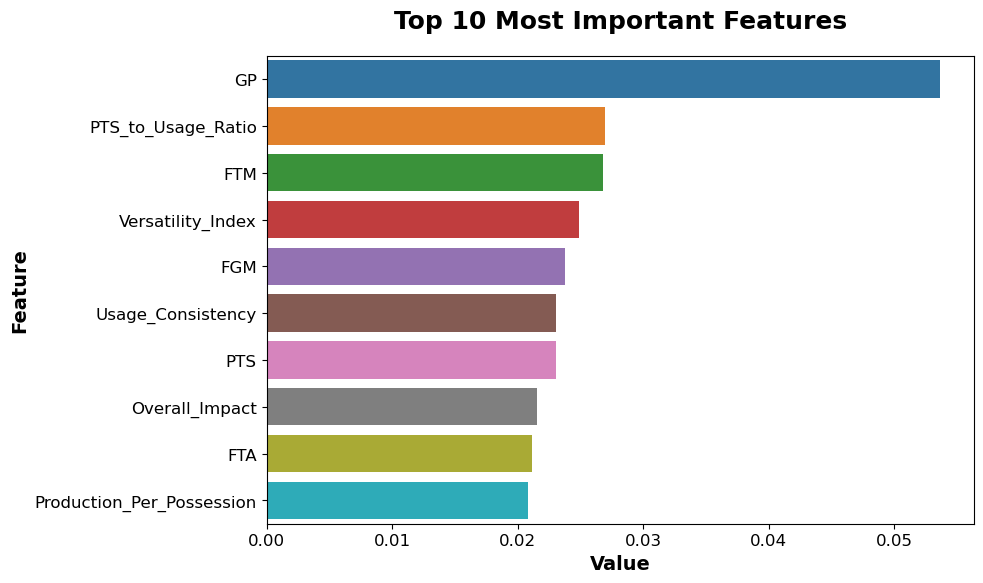

8. PLOT ROC CURVE


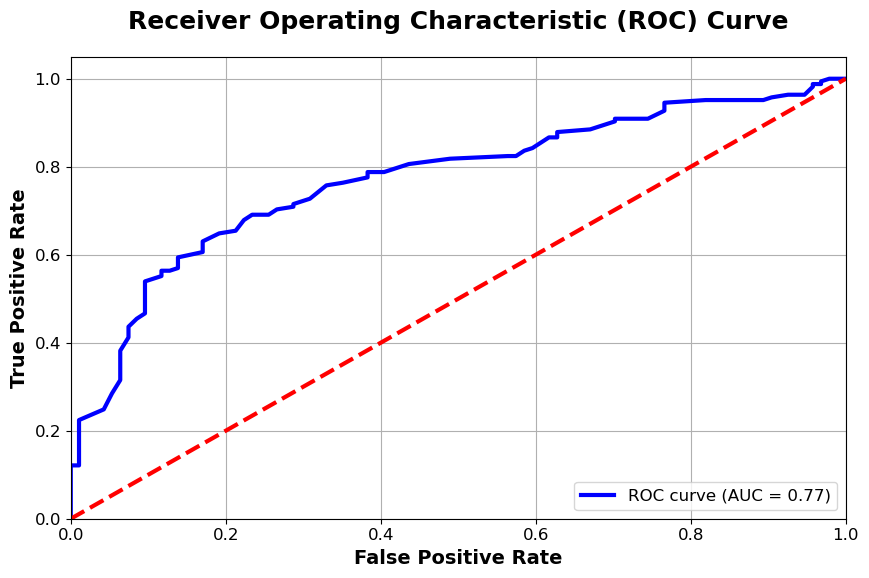

9. PLOT PRECISION-RECALL CURVE


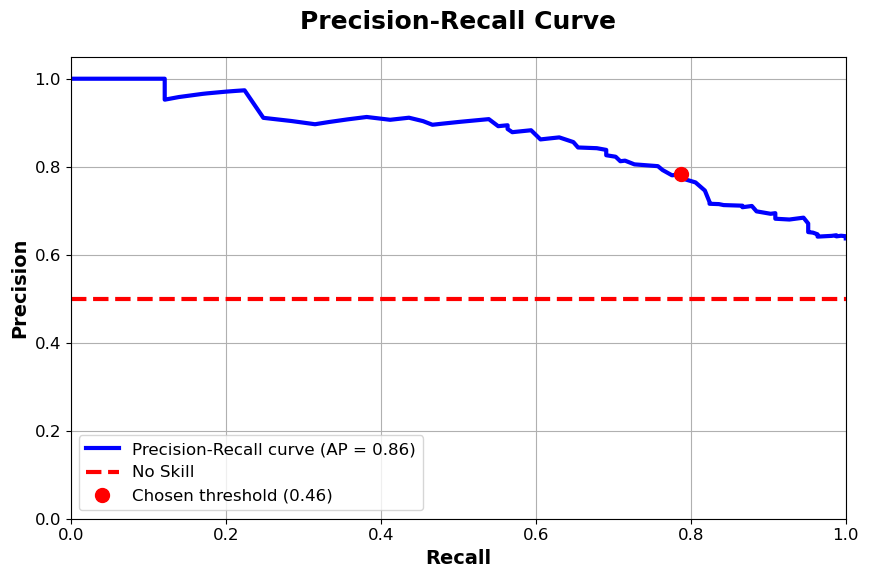

In [3]:
# ==================================================================
# MAIN
# ==================================================================

# Define a dictionary of classifiers for evaluation
CLASSIFIERS = {
    'SVC': SVC,
    'RandomForest': RandomForestClassifier,
    'LogisticRegression': LogisticRegression,
    'MLPClassifier': MLPClassifier,
    'GradientBoosting': GradientBoostingClassifier,
    'XGBoost': XGBClassifier,
    'AdaBoost': AdaBoostClassifier,
    'KNeighbors': KNeighborsClassifier
}

# Set plot styling for visualizations
set_plot_style()

# ==================================================================
# Step 1: Load and preprocess the dataset
# ==================================================================
print("1. LOAD and PREPROCESS DATA")
X, y, feature_names, names, scaler  = load_and_preprocess_data('nba_logreg_clean_WITH_FE.csv')

# ==================================================================
# Step 2: Split the data into training and test sets
# ==================================================================
print("2. SPLIT DATA")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==================================================================
# Step 3: Apply SMOTE to handle class imbalance in the training set
# ==================================================================
print("3. APPLY SMOTE")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ==================================================================
# Step 4: Evaluate multiple classifiers on the resampled training data
# ==================================================================
print("4. EVALUATE CLASSIFIERS")
results_df = evaluate_classifiers(X_train_resampled, y_train_resampled)
display(results_df)

# Select the best-performing classifier based on evaluation results
best_classifier = results_df.iloc[0]['Classifier']
best_threshold = results_df.iloc[0]['Optimal_Threshold']
print(f"\nBest performing classifier: {best_classifier}")
print(f"Optimal threshold for best classifier: {best_threshold:.4f}")

# ==================================================================
# Step 5: Perform hyperparameter tuning for the best classifier
# ==================================================================
print("5. HYPERPARAMETER TUNING")
best_model = tune_hyperparameters(X_train_resampled, y_train_resampled, best_classifier)

# ==================================================================
# Step 6: Final evaluation on the test dataset
# ==================================================================
print("6. FINAL EVALUATION ON TEST DATASET")
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else y_pred

# Use optimal threshold for predictions
y_pred = (y_prob >= best_threshold).astype(int)

# Output performance metrics
print("Final model performance on test set:")
print(classification_report(y_test, y_pred))
print(f"Final AUC ROC: {roc_auc_score(y_test, y_prob):.4f}")

# ==================================================================
# Step 7: Visualize feature importance (for tree-based models)
# ==================================================================
print("7. PLOT FEATURE IMPORTANCE")
plot_feature_importance(best_model, feature_names)

# ==================================================================
# Step 8: Plot ROC curve for the final model
# ==================================================================
print("8. PLOT ROC CURVE")
plot_roc_curve(y_test, y_prob)

# ==================================================================
# Step 9: Plot precision-recall curve
# ==================================================================
print("9. PLOT PRECISION-RECALL CURVE")
plot_precision_recall_curve(y_test, y_prob, best_threshold)

In [4]:
# ==================================================================
# SAVE MODEL VIA JOBLIB
# ==================================================================
from joblib import dump

# Step 8: Save the trained model
print("10. SAVE TRAINED MODEL")
model_filename = 'nba_career_prediction_model.joblib'
dump(best_model, model_filename)
dump(feature_names, 'feature_names.joblib')
dump(scaler, 'scaler.joblib')  # Assuming you used MinMaxScaler earlier
print("Model, feature names, and scaler saved successfully.")


10. SAVE TRAINED MODEL
Model, feature names, and scaler saved successfully.


In [5]:
# ==================================================================
# SAVE Treshold 
# ==================================================================
# Save the best threshold to a text file
best_threshold = results_df.iloc[0]['Optimal_Threshold']

with open('decision_threshold.txt', 'w') as f:
    f.write(f'{best_threshold:.4f}')

print(f"Best threshold {best_threshold:.4f} saved to 'decision_threshold.txt'")

Best threshold 0.4567 saved to 'decision_threshold.txt'


In [6]:
feature_names

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM',
       'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PER',
       'PPM', 'Usage_Rate', 'True_Shooting_Percentage',
       'Effective_FG_Percentage', 'Points_Per_Shot',
       'Total_Rebound_Percentage', 'Offensive_Rebound_Percentage',
       'Defensive_Rebound_Percentage', 'Assist_Percentage', 'AST_Ratio',
       'Steal_Percentage', 'Block_Percentage', 'Stocks', 'Versatility_Index',
       'Offensive_Versatility', 'Defensive_Versatility', 'Three_Point_Rate',
       'Free_Throw_Rate', 'PTS_Per_Game', 'PTS_Per_36', 'REB_Per_Game',
       'REB_Per_36', 'AST_Per_Game', 'AST_Per_36', 'STL_Per_Game',
       'STL_Per_36', 'BLK_Per_Game', 'BLK_Per_36', 'TOV_Per_Game',
       'TOV_Per_36', 'Box_Plus_Minus', 'Scoring_Consistency',
       'Usage_Consistency', 'Offensive_Impact', 'Defensive_Impact',
       'Overall_Impact', 'Points_Per_Touch', 'Production_Per_Possession',
       'PTS_to_Usage_Ratio'